<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Лемматизация-и-очистка-текстов" data-toc-modified-id="Лемматизация-и-очистка-текстов-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация и очистка текстов</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучение-моделей-без-учёта-дисбаланса-классов" data-toc-modified-id="Обучение-моделей-без-учёта-дисбаланса-классов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучение моделей без учёта дисбаланса классов</a></span></li><li><span><a href="#Балансировка-классов" data-toc-modified-id="Балансировка-классов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Балансировка классов</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

<div style="border:solid lightblue 3px; padding: 20px">
    
Наш заказчик: 
    
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Наша задача:** 
    
Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Наша цель:** 
    
Построить модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# читаем файл
try: # пробуем загрузить данные с платформы...
    toxic = pd.read_csv('/datasets/toxic_comments.csv')
except: # в случае неудачи загружаем данные локально
    toxic = pd.read_csv('c:\\toxic_comments.csv')

In [3]:
# выводим общую информацию
toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
# просматриваем первые строки датасета
toxic.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


0    0.898388
1    0.101612
Name: toxic, dtype: float64


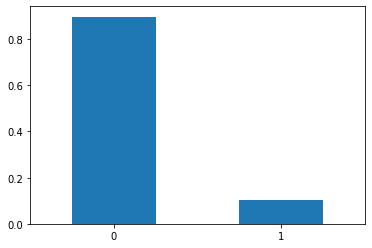

In [5]:
# проанализируем частоты классов целевого признака по умолчанию
class_frequency = toxic['toxic'].value_counts(normalize=True)
print(class_frequency)

class_frequency.plot(kind='bar', rot=1)
plt.show()

### Вывод

**Описание данных**

**Данные находятся в файле `toxic_comments.csv`. Столбец `text` в нём содержится текст комментария, а `toxic` — целевой признак.**


**Здесь мы видим, что у нас есть 159 571 записей. Из них около 10% это комментарии, которые содержат токсичные слова, требующие премодерации. Из выведенных данных мы видим, что у нас в наличие дисбаланс классов. Потому ниже постараемся избавится от дисбаланса при обучении моделей. И на основе исследования борьбы подберём наиболее подходящую модель.**

### Лемматизация и очистка текстов

In [6]:
# запишем функцию, которая создаёт леммы из текста
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([lemmatizer.lemmatize(w) for w in lemm_list])
        
    return lemm_text

# запишем функцию, которая будет очищать текст, или наши леммы
def clear_text(text):
    pattern = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = ' '.join(pattern.split())
    
    return clear_text

# создаём очищенные леммы, и вносим их в новый столбец в наших данных
toxic['lemm_text'] = toxic['text'].apply(lambda x: lemmatize(clear_text(x)))

In [7]:
# просмотрим результат
toxic.head()

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,D aww He match this background colour I m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid"> Как мы видим у нас удалось вычислить леммы, и очистить их от стоп-слов. </div>

## Обучение

In [8]:
features = toxic['lemm_text'].values # вносим в переменные в признаки наши очищенные леммы,
target = toxic['toxic'].values # а в целевые признаки является ли текст токсичным

In [9]:
# делим наши выборки на обучаемую и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, stratify=target, random_state=12345)

In [10]:
# проверяем разделение выборок
print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)

(95575,)
(63717,)
(95575,)
(63717,)


In [11]:
# повторно делим выборки уже на валидационную и тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, stratify=target_valid, random_state=12345)

In [12]:
# проверяем разделение выборок
print(features_valid.shape)
print(features_test.shape)
print(target_valid.shape)
print(target_test.shape)

(31858,)
(31859,)
(31858,)
(31859,)


In [13]:
# вносим в переменную стоп-слова
stopwords = set(nltk_stopwords.words('english'))

# вносим в переменную наш векторайзер
count_tf_idf = TfidfVectorizer(stop_words=stopwords)# в последствии отказался от , max_features=5000)

In [14]:
# создаём признаки при помощи нашего векторайзера
tf_idf_train = count_tf_idf.fit_transform(features_train)

tf_idf_valid = count_tf_idf.transform(features_valid)

tf_idf_test = count_tf_idf.transform(features_test)

### Обучение моделей без учёта дисбаланса классов

In [15]:
# заносим в переменную настроенную модель дерева решения
DTC_model = DecisionTreeClassifier(random_state=12345, 
                                   max_depth=3, 
                                   min_samples_leaf=7, 
                                   min_samples_split=4
                                  )

# обучаем модель на тренировочных данных
DTC_model.fit(tf_idf_train,target_train)

# заносим в переменную предсказания модели
DTC_predicted_valid = pd.Series(DTC_model.predict(tf_idf_valid))

# производим вычисления оценки AUC-ROC
DTC_probabilities_valid = DTC_model.predict_proba(tf_idf_valid)
DTC_probabilities_one_valid = DTC_probabilities_valid[:, 1]
DTC_auc_roc_default = roc_auc_score(target_valid, DTC_probabilities_one_valid)

# вносим в переменную F1-меру по умолчанию
DTC_f1_default = f1_score(target_valid, DTC_predicted_valid)

# выводим на экран оценку F1-меры
print('F1-мера дерева решений \n без учёта дисбаланса = {:.2f}'.format(DTC_f1_default))

# выводим на экран оценку AUC-ROC
print('AUC-ROC дерева решений \n без учёта дисбаланса = {:.2f}'.format(DTC_auc_roc_default))

F1-мера дерева решений 
 без учёта дисбаланса = 0.43
AUC-ROC дерева решений 
 без учёта дисбаланса = 0.64


In [16]:
# вносим в переменную нашу настроенную модель
RFC_model = RandomForestClassifier(random_state=12345,
                                   n_estimators=10,
                                   min_samples_leaf=4,
                                   min_samples_split=6,
                                   max_depth=3
                                  )

# обучаем модель на тренировочных данных
RFC_model.fit(tf_idf_train, target_train)

# заносим в переменную предсказания модели
RFC_predicted_valid = pd.Series(RFC_model.predict(tf_idf_valid))

# производим вычисления оценки AUC-ROC
RFC_probabilities_valid = RFC_model.predict_proba(tf_idf_valid)
RFC_probabilities_one_valid = RFC_probabilities_valid[:, 1]
RFC_auc_roc_default = roc_auc_score(target_valid, RFC_probabilities_one_valid)

# вносим в переменную F1-меру по умолчанию
RFC_f1_default = f1_score(target_valid, RFC_predicted_valid)

# выводим на экран оценку F1-меры
print('F1-мера случайного леса \n без учёта дисбаланса = {:.2f}'.format(RFC_f1_default))

# выводим на экран оценку AUC-ROC
print('AUC-ROC случайного леса \n без учёта дисбаланса = {:.2f}'.format(RFC_auc_roc_default))

F1-мера случайного леса 
 без учёта дисбаланса = 0.00
AUC-ROC случайного леса 
 без учёта дисбаланса = 0.61


In [17]:
# вносим в переменную нашу настроенную модель
LR_model = LogisticRegression(random_state=12345, max_iter=420, solver='liblinear')

# обучаем модель на тренировочных данных
LR_model.fit(tf_idf_train, target_train)

#заносим в переменную предсказания модели
LR_predicted_valid = pd.Series(LR_model.predict(tf_idf_valid))

# производим вычисления оценки AUC-ROC
LR_probabilities_valid = LR_model.predict_proba(tf_idf_valid)
LR_probabilities_one_valid = LR_probabilities_valid[:, 1]
LR_auc_roc_default = roc_auc_score(target_valid, LR_probabilities_one_valid)

# вносим в переменную F1-меру по умолчанию
LR_f1_default = f1_score(target_valid, LR_predicted_valid)

# выводим на экран оценку F1-меры
print('F1-мера логистической регрессии \n без учёта дисбаланса = {:.2f}'.format(LR_f1_default))

# выводим на экран оценку AUC-ROC
print('AUC-ROC логистической реграссии \n без учёта дисбаланса = {:.2f}'.format(LR_auc_roc_default))

F1-мера логистической регрессии 
 без учёта дисбаланса = 0.72
AUC-ROC логистической реграссии 
 без учёта дисбаланса = 0.97


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid"> Как мы видим после обучения моделей без учёта дисбаланса наиболее перспективной моделью себя показала логистическая регрессия. По смотрим далее, что произойдёт с показателями моделей после баланисровки классов. </div>

### Балансировка классов

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid"> Ниже произведём сбалансированное взвешивание классов, а также постараемся найти необходимый для нас порог значений, чтобы максимально улучшить значение F1-меры. </div>

In [18]:
# заносим в переменную настроенную модель дерева решения
DTC_model = DecisionTreeClassifier(random_state=12345, 
                                   max_depth=3, 
                                   min_samples_leaf=7, 
                                   min_samples_split=4,
                                   # добавляем гиперпараметр взвешивания классов
                                   class_weight='balanced'
                                  )

# обучаем модель на тренировочных данных
DTC_model.fit(tf_idf_train,target_train)

THRESHOLD_DTC = 0.5 # найденный наилучший порог значений

# вносим в переменную предсказания модели с учётом порога
DTC_predicted_valid = np.where(
    DTC_model.predict_proba(tf_idf_valid)[:,1] > THRESHOLD_DTC, 1, 0)

# выводим на экран оценку F1-меры
print('F1-мера дерева решений \n при сбалансированных классах =',
      f1_score(target_valid, DTC_predicted_valid).round(2))

    

F1-мера дерева решений 
 при сбалансированных классах = 0.38


In [19]:
# заносим в переменную настроенную модель случайного леса
RFC_model = RandomForestClassifier(random_state=12345,
                                   n_estimators=10,
                                   min_samples_leaf=4,
                                   min_samples_split=6,
                                   max_depth=3,
                                   # добавляем гиперпараметр взвешивания классов
                                   class_weight='balanced'
                                  )

# обучаем модель на тренировочных данных
RFC_model.fit(tf_idf_train, target_train)

THRESHOLD_RFC = 0.52 # найденный наилучший порог значений

# вносим в переменную предсказания модели с учётом порога
RFC_predicted_valid = np.where(
    RFC_model.predict_proba(tf_idf_valid)[:,1] > THRESHOLD_RFC, 1, 0)

# выводим на экран оценку F1-меры
print('F1-мера случайного леса \n при сбалансированных классах =', 
      f1_score(target_valid, RFC_predicted_valid).round(2))

F1-мера случайного леса 
 при сбалансированных классах = 0.19


In [20]:
# заносим в переменную настроенную модель логистической регрессии
LR_model = LogisticRegression(
    random_state=12345,
    max_iter=420,
    # добавляем гиперпараметр взвешивания классов
    class_weight='balanced',
    solver='liblinear')

# обучаем модель на тренировочных данных
LR_model.fit(tf_idf_train, target_train)

THRESHOLD_LR = 0.64 # найденный наилучший порог значений

# вносим в переменную предсказания модели с учётом порога
LR_predicted_valid = np.where(
    LR_model.predict_proba(tf_idf_valid)[:,1] > THRESHOLD_LR, 1, 0)

# выводим на экран оценку F1-меры
print('F1-мера логистической регрессии \n при сбалансированных классах =',
      f1_score(target_valid,LR_predicted_valid).round(2))

F1-мера логистической регрессии 
 при сбалансированных классах = 0.78


<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid"> Что в принципе и стоило доказать, что наиболее удачной для нашей задачи показала себя модель логистической регрессии. Потому ниже и проведём её тестирование. </div>

## Тестирование модели

In [21]:
# вносим в переменную предсказания на тестовой выборке
LR_predicted_test = np.where(
    LR_model.predict_proba(tf_idf_test)[:,1] > THRESHOLD_LR, 1, 0)

# выводим на экран оценку F1-меры
print('F1-мера логистической регрессии на тестовой выборке \n'
      'при сбалансированных классах и выбранном пороге =',
      f1_score(target_test,LR_predicted_test).round(2))

F1-мера логистической регрессии на тестовой выборке 
при сбалансированных классах и выбранном пороге = 0.76


## Выводы

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid">
    
В ходе работы над проектом было сделано:

- Подготовленны данные перед обучением на моделях.
- Поделены данные на обучающую, валидационную и тестовую выборку.
- Обучены модели и выбраны лучшие из них на валидационной выборке.
- Показаны параметры качества моделей.

Исходные данные обладают большим количеством признаков. Созданных столбцов больше, чем записей данных. Так как TF-IDF превращают текст в численные значения, лучшими моделями стала LogisticRegression. 

На тестовой выбоке по метрике F1-мера лучше всего себя показала логистическая регрессия (LogisticRegression) = 0.76.
    
</div>